In [911]:
import pandas as pd
import datetime
from datetime import date
import itertools
import pandas_datareader.data as web
from pandas import Series, DataFrame

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

import math
import numpy as np
import sklearn

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

#for at nederste grafen skal predicte noe i nærheten av nåtiden så må denne verdien endres til noe mellom 0.1 - 0.01
multiply = 0.05
#men da vil ikke predictoren kunne virke langt frem i tid da denne verdien viser til hvor mye data som skal føres inn i
#datasettet. Jo høyere dette tallet er jo mindre prosent riktig vil algoritmen tro at den tar riktig



In [912]:
startdato = datetime.datetime(2010, 1, 1)
dagensdato = datetime.date.today()

#importer fra nettsiden slik at dataen alltid vil være oppdatert og det er 
#lettere å endre/legge til andre aksjer
df = web.DataReader("TSLA", 'yahoo', startdato, dagensdato)

In [913]:
closeprice = df['Adj Close']
mavg = closeprice.rolling(window=100).mean()
#bevegende gjennomsnitt for de siste 100 dager
mavg.tail()

Date
2021-10-12    689.464698
2021-10-13    691.766698
2021-10-14    693.885498
2021-10-15    696.268898
2021-10-18    698.778698
Name: Adj Close, dtype: float64

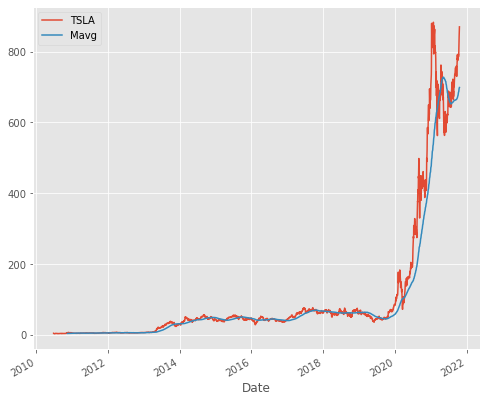

In [914]:
#piffe grafen litt opp
mpl.rc('figure', figsize=(8,7))
mpl.__version__

style.use('ggplot')

closeprice.plot(label='TSLA')
mavg.plot(label='Mavg')
plt.legend()

<AxesSubplot:xlabel='Date'>

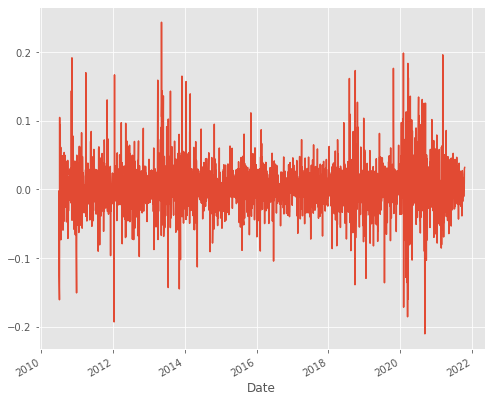

In [915]:
#formel for forventet verdi
returnValue = closeprice / closeprice.shift(1)-1
returnValue.plot(label='Return Value')

In [916]:
df2 = df.loc[:,['Adj Close','Volume']]
df2['HighLow_Percent'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df2['Percent_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
#feature enginering 
# for endring i prosent og prosent forskjell mellom dagens høyeste pris
# og laveste pris

In [917]:
#dropper manglede verdier
df2.fillna(value=-99999, inplace=True)

# separerer 2% av dataen til forecastedOut
forecastedOut = int(math.ceil(multiply * len(df2)))

#Separerer labelen for å spå Adj Close
forecast = 'Adj Close'
df2['label'] = df2[forecast].shift(-forecastedOut)
X = np.array(df2.drop(['label'], 1))

# Skalerer X slik at den vil ha samme distrubisjon for en linear regression modell
X = preprocessing.scale(X)

#Finne dataserien for gammel og "i det siste" X for å trene modellen 
XLately = X[-forecastedOut:]
X = X[:-forecastedOut]

#separerer labelen og setter den i y
y = np.array(df2['label'])
y = y[:-forecastedOut]

C:\Users\Brian\AppData\Local\Temp/ipykernel_11432/2315600339.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df2.drop(['label'], 1))


In [918]:
# trene modellen
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2)

In [919]:
# Linear regression modell
clfreg = LinearRegression(n_jobs=-1)
#n_jobs=-1 setter alle prosessrorene i arbeid 
clfreg.fit(XTrain, yTrain)

LinearRegression(n_jobs=-1)

In [920]:
forecastSet = clfreg.predict(XLately)
df2['Forecast'] = np.nan
#print(forecastSet)

#viser noen av de spådde verdiene ved børsstenging

0.7968442361135576
Date
2021-12-12    699.888598
Name: Forecast, dtype: float64


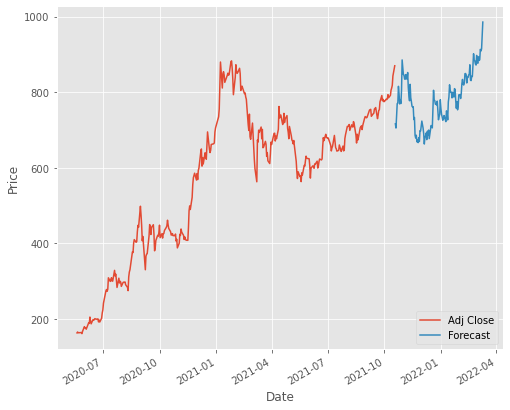

In [921]:
lastClosingDate = df2.iloc[-1].name
#henter den ferskeste dataen, slik at modellen kun viser spåingen i fremtiden

lastPrediction = lastClosingDate
nextPrediction = lastPrediction + datetime.timedelta(days=1)
#for å endre i antall dager endre verdien i "datetime.timedelta(days=1)"


#hvor riktig modellen tror den er i %
confidencePercent = clfreg.score(XTest, yTest)
print(confidencePercent)


##itertools.islice(forecastSet, 500):
for i in forecastSet:
    PredictedDate = nextPrediction
    nextPrediction += datetime.timedelta(days=1)
    df2.loc[PredictedDate] = [np.nan for _ in range(len(df2.columns)-1)]+[i]
df2['Adj Close'].tail(500).plot()
df2['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
#Her kan du lete etter pris for bestemt dato
#Men husk at hvis du vil lete langt inn i fremtiden så må multiply være større
print(df2["Forecast"].loc["2021, 12, 12" : "2021, 12, 12"])

plt.show()